Importing all the required libs and initializing h2o cluster.

- pandas: dataset manipulation
- numpy: arrays operation
- matplotlib: plots
- sklearn: most used machine learning library
- h2o: better machine learning library


In [116]:
import pandas as pd
import numpy as np
import h2o
import matplotlib.pyplot as plt

from sklearn import *
from h2o.estimators.random_forest import *

h2o.init()

%matplotlib inline

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,10 hours 17 mins
H2O cluster version:,3.10.0.8
H2O cluster version age:,4 months and 8 days !!!
H2O cluster name:,H2O_from_python_mateus_usued1
H2O cluster total nodes:,1
H2O cluster free memory:,3.388 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Loading the dataset.

In [39]:
df = pd.read_csv('~/Downloads/megasena.csv', sep=';')
df.head()

,id,data,n1,n2,n3,n4,n5,n6,arrec,ganhadores,...,uf,rateio_sena,Ganhadores_Quina,Rateio_Quina,Ganhadores_Quadra,Rateio_Quadra,Acumulado,Valor_Acumulado,Estimativa_Pr�mio,Acumulado_Mega_da_Virada
0,1,11/03/96,41.0,5.0,4.0,52.0,30.0,33.0,0,0.0,...,NaN,0,17.0,"39.158,92",2016.0,"330,21",SIM,"1.714.650,23",0,0
1,2,18/03/1996,9.0,39.0,37.0,49.0,43.0,41.0,0,1.0,...,PR,"2.307.162,23",65.0,"14.424,02",4488.0,"208,91",N�O,0,0,0
2,3,25/03/1996,36.0,30.0,10.0,11.0,29.0,47.0,0,2.0,...,RN,"391.192,51",62.0,"10.515,93",4261.0,"153,01",N�O,0,0,0
3,NaN,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,01/04/96,6.0,59.0,42.0,27.0,1.0,5.0,0,0.0,...,NaN,0,39.0,"15.322,24",3311.0,"180,48",SIM,"717.080,75",0,0


## Preprocessing

Before dumping the dataset into the learning algorithms, we need to clean and preprocess the dataset.
What I'm doing:

- removing invalid lines (id or n1 is null)
- selecting features that maybe could add signal on the prediction (date, balls, id, acumulado)
- generating features that are not on the dataset but maybe can add signal (week, year, month, if id ends with 0 or 5, line, column and "quadrantes" of the balls)
- flattening the dataset: the way we're modelling is to predict one number at a time, so we need one row per ball, not per game. But as the 2nd ball depends on the result of the first, I'm introducing the preceding balls as features for the next ones.


In [49]:

columns = [ 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'data', 'id', 'Acumulado_Mega_da_Virada', 'Acumulado' ]
data    = df[ ~( df['id'].isnull() | df['n1'].isnull() ) ][ columns ].reset_index()

for b in range(1,7):
    data["n%d" % b] = data["n%d" % b].astype('int')

for i in range(1,7):
    data["l%d" % i] = (( data["n%d" % i] - 1 ) / 10).astype('int')
    data["c%d" % i] = (( data["n%d" % i] - 1 ) % 10).astype('int')
    data["q%d" % i] = ( data["l%d" % i] / 2 ).astype('int')*10 + ( data["c%d" % i] / 2 ).astype('int')

data.head(12)

,index,n1,n2,n3,n4,n5,n6,data,id,Acumulado_Mega_da_Virada,...,q3,l4,c4,q4,l5,c5,q5,l6,c6,q6
0,0,41,5,4,52,30,33,11/03/96,1,0,...,1,5,1,20,2,9,14,3,2,11
1,1,9,39,37,49,43,41,18/03/1996,2,0,...,13,4,8,24,4,2,21,4,0,20
2,2,36,30,10,11,29,47,25/03/1996,3,0,...,4,1,0,0,2,8,14,4,6,23
3,4,6,59,42,27,1,5,01/04/96,4,0,...,20,2,6,13,0,0,0,0,4,2
4,5,1,19,46,6,16,2,08/04/96,5,0,...,22,0,5,2,1,5,2,0,1,0
5,6,19,40,7,13,22,47,15/04/1996,6,0,...,3,1,2,1,2,1,10,4,6,23
6,7,56,38,21,20,3,5,22/04/1996,7,0,...,10,1,9,4,0,2,1,0,4,2
7,8,53,17,38,4,47,37,29/04/1996,8,0,...,13,0,3,1,4,6,23,3,6,13
8,9,55,43,56,54,8,60,06/05/96,9,0,...,22,5,3,21,0,7,3,5,9,24
9,10,25,4,18,57,21,38,13/05/1996,10,0,...,3,5,6,23,2,0,10,3,7,13


Checking that my line/column/quadrante calculations are correct

In [27]:
print "Linhas"
for i in sorted(df['l1'].unique()):
    print i, sorted(df[df["l1"] == i]["n1"].unique())
    
print "Colunas"
for i in sorted(df['c1'].unique()):
    print i, sorted(df[df["c1"] == i]["n1"].unique())

print "Quadrantes"
for i in sorted(df['q1'].unique()):
    print i, sorted(df[df["q1"] == i]["n1"].unique())

Linhas
0 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
1 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
2 [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
3 [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
4 [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
5 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Colunas
0 [1, 11, 21, 31, 41, 51]
1 [2, 12, 22, 32, 42, 52]
2 [3, 13, 23, 33, 43, 53]
3 [4, 14, 24, 34, 44, 54]
4 [5, 15, 25, 35, 45, 55]
5 [6, 16, 26, 36, 46, 56]
6 [7, 17, 27, 37, 47, 57]
7 [8, 18, 28, 38, 48, 58]
8 [9, 19, 29, 39, 49, 59]
9 [10, 20, 30, 40, 50, 60]
Quadrantes
0 [1, 2, 11, 12]
1 [3, 4, 13, 14]
2 [5, 6, 15, 16]
3 [7, 8, 17, 18]
4 [9, 10, 19, 20]
10 [21, 22, 31, 32]
11 [23, 24, 33, 34]
12 [25, 26, 35, 36]
13 [27, 28, 37, 38]
14 [29, 30, 39, 40]
20 [41, 42, 51, 52]
21 [43, 44, 53, 54]
22 [45, 46, 55, 56]
23 [47, 48, 57, 58]
24 [49, 50, 59, 60]


In [50]:
data['id5']       = data['id'].astype('int') % 5
data['acumulado'] = data['Acumulado'] == 'SIM'
data['virada']    = data['Acumulado_Mega_da_Virada'] != '0'

data['data']  = pd.to_datetime(data['data'])
data['week']  = data['data'].dt.week
data['month'] = data['data'].dt.month 
data['year']  = data['data'].dt.year

data          = data.drop([ 'index', 'data', 'id', 'Acumulado', 'Acumulado_Mega_da_Virada' ], axis=1)
data.head(12)

,n1,n2,n3,n4,n5,n6,l1,c1,q1,l2,...,q5,l6,c6,q6,id5,acumulado,virada,week,month,year
0,41,5,4,52,30,33,4,0,20,0,...,14,3,2,11,1,True,False,44,11,1996
1,9,39,37,49,43,41,0,8,4,3,...,21,4,0,20,2,False,False,12,3,1996
2,36,30,10,11,29,47,3,5,12,2,...,14,4,6,23,3,False,False,13,3,1996
3,6,59,42,27,1,5,0,5,2,5,...,0,0,4,2,4,True,False,1,1,1996
4,1,19,46,6,16,2,0,0,0,1,...,2,0,1,0,0,True,False,31,8,1996
5,19,40,7,13,22,47,1,8,4,3,...,10,4,6,23,1,True,False,16,4,1996
6,56,38,21,20,3,5,5,5,22,3,...,1,0,4,2,2,True,False,17,4,1996
7,53,17,38,4,47,37,5,2,21,1,...,23,3,6,13,3,True,False,18,4,1996
8,55,43,56,54,8,60,5,4,22,4,...,3,5,9,24,4,True,False,23,6,1996
9,25,4,18,57,21,38,2,4,12,0,...,10,3,7,13,0,True,False,20,5,1996


In [117]:
def flatten(df): 
    flat = pd.DataFrame(index=list(range(0, df.shape[0]*6)), columns=list(df.columns) + [ 'label', 'bola' ])
    for r, row in df.iterrows():
        for j in range(1,7):
            i = r * 6 + j - 1
            flat.ix[i] = row
            flat.ix[i, 'bola' ] = j
            flat.ix[i, 'label'] = row["n%d" % j]
            for k in range(j, 7):
                flat.ix[i, "n%d" % k] = None
                flat.ix[i, "c%d" % k] = None
                flat.ix[i, "l%d" % k] = None
                flat.ix[i, "q%d" % k] = None
    return flat

flat = flatten(data)
flat.head(12)

,n1,n2,n3,n4,n5,n6,l1,c1,q1,l2,...,c6,q6,id5,acumulado,virada,week,month,year,label,bola
0,None,None,None,None,None,None,None,None,None,None,...,None,None,1,True,False,44,11,1996,41,1
1,41,None,None,None,None,None,4,0,20,None,...,None,None,1,True,False,44,11,1996,5,2
2,41,5,None,None,None,None,4,0,20,0,...,None,None,1,True,False,44,11,1996,4,3
3,41,5,4,None,None,None,4,0,20,0,...,None,None,1,True,False,44,11,1996,52,4
4,41,5,4,52,None,None,4,0,20,0,...,None,None,1,True,False,44,11,1996,30,5
5,41,5,4,52,30,None,4,0,20,0,...,None,None,1,True,False,44,11,1996,33,6
6,None,None,None,None,None,None,None,None,None,None,...,None,None,2,False,False,12,3,1996,9,1
7,9,None,None,None,None,None,0,8,4,None,...,None,None,2,False,False,12,3,1996,39,2
8,9,39,None,None,None,None,0,8,4,3,...,None,None,2,False,False,12,3,1996,37,3
9,9,39,37,None,None,None,0,8,4,3,...,None,None,2,False,False,12,3,1996,49,4


## Data exploration

This step should come along with the data preprocessing step. We want to become used to the nature of our dataset, so we can choose the best algorithms, clean the data properly, uncover hidden relationships on the data and gain some insights on which features could we generate that might add value.

Said that, i shortened this step and just validated that there is some variation on the selected balls (otherwise there would be no point in trying to predict them).


In [69]:
def frequency(df, cols):
    counts = np.array(61 * [ 0 ])
    for i,row in df.iterrows():
        for c in cols: counts[row[c]] += 1
    return counts[ counts != 0 ]

def plot_frequency(df, cols, title=None, ax=plt):
    vals = frequency(df, cols)
    ax.bar(range(1, len(vals)+1), -1 + vals / vals.mean(), label="Media: %.1f" % vals.mean())
    ax.set_xlim([1, len(vals)])
    ax.set_title(title)
    ax.set_ylabel("% sobre a media")
    ax.legend()


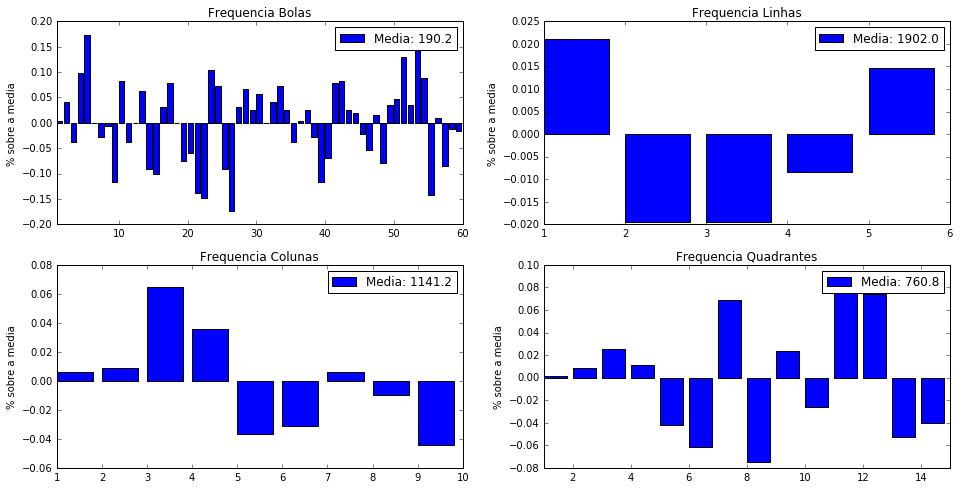

In [70]:
plt.figure(figsize=(16,8))
plot_frequency(data, [ 'n1', 'n2', 'n3', 'n4', 'n5', 'n6' ], title="Frequencia Bolas", ax=plt.subplot(221))
plot_frequency(data, [ 'l1', 'l2', 'l3', 'l4', 'l5', 'l6' ], title="Frequencia Linhas", ax=plt.subplot(222))
plot_frequency(data, [ 'c1', 'c2', 'c3', 'c4', 'c5', 'c6' ], title="Frequencia Colunas", ax=plt.subplot(223))
plot_frequency(data, [ 'q1', 'q2', 'q3', 'q4', 'q5', 'q6' ], title="Frequencia Quadrantes", ax=plt.subplot(224))

## Random Forest

didnt have time to write

In [85]:
features = flat.columns[ ~np.in1d(flat.columns, [ 'label' ]) ].tolist()
h2o_df = H2OFrame(flat)
for c in h2o_df.columns:
    h2o_df[c] = h2o_df[c].asfactor()

Rows:11412
Cols:32




,n1,n2,n3,n4,n5,n6,l1,c1,q1,l2,c2,q2,l3,c3,q3,l4,c4,q4,l5,c5,q5,l6,c6,q6,id5,acumulado,virada,week,month,year,label,bola
type,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.761303890641,0.473711882229,NaN,NaN,NaN,NaN,NaN
maxs,59.0,59.0,59.0,60.0,60.0,0.0,5.0,9.0,14.0,5.0,9.0,14.0,6.0,10.0,15.0,6.0,10.0,15.0,6.0,10.0,15.0,0.0,0.0,0.0,4.0,1.0,1.0,52.0,11.0,21.0,59.0,5.0
sigma,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.426305291715,0.499330334536,NaN,NaN,NaN,NaN,NaN
zeros,160,140,105,74,26,11412,1640,925,675,1392,828,536,909,597,393,626,396,242,315,178,124,11412,11412,11412,2280,2724,6006,204,948,258,191,1902
missing,1902,3804,5706,0,0,0,1902,1902,1902,3804,3804,3804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,,,,None,None,None,,,,,,,None,None,None,None,None,None,None,None,None,None,None,None,1,True,False,44,11,1996,41,1
1,41,,,None,None,None,4,0,20,,,,None,None,None,None,None,None,None,None,None,None,None,None,1,True,False,44,11,1996,5,2
2,41,5,,None,None,None,4,0,20,0,4,2,None,None,None,None,None,None,None,None,None,None,None,None,1,True,False,44,11,1996,4,3


In [115]:
rf = H2ORandomForestEstimator( max_depth=50, nfolds=3 )
rf.train(training_frame=h2o_df, x=features, y='label')
rf.cross_validation_metrics_summary()

drf Model Build progress: |███████████████████████████████████████████████████████████████████| 100%
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.0068358,0.0004613,0.0067045,0.0061105,0.0076923
err,0.9931642,0.0004613,0.9932955,0.9938894,0.9923077
err_count,3778.0,37.0,3852.0,3741.0,3741.0
logloss,18.228333,0.1900964,18.597204,18.123646,17.964146
max_per_class_error,1.0,0.0,1.0,1.0,1.0
mean_per_class_accuracy,0.0065998,0.0004775,0.0067314,0.0057148,0.0073532
mean_per_class_error,0.9934002,0.0004775,0.9932686,0.9942852,0.9926468
mse,0.9765536,0.0003764,0.977108,0.9767176,0.9758353
r2,0.9967591,0.0000259,0.9968073,0.9967515,0.9967183
rmse,0.9882073,0.0001905,0.9884877,0.9882903,0.9878438


In [118]:
acc = []
for i in range(0, 100):
    preds = np.random.randint(1, 61, size=flat.shape[0])
    equal = [ preds[i] == flat['label'][i] for i in range(0, len(preds)) ]
    acc += [ np.sum(equal) * 1.0 / flat.shape[0] ]

np.mean(acc), np.std(acc) 

(0.016749912372940764, 0.0010908337099678148)

## Todo

In [ ]:
def bootstrap_sample(df, n=None):
    n       = n or df.shape[0]
    sample  = np.random.randint(n, size=n)
    indexes = df.index[sample]
    return df[indexes], df[~np.in1d(df.index, indexes)]

def evaluate_group(model, row, true):
    for i in range(1,7):
        predictions += model.predict([ row ])
        row["n%d" % i] = predictions[-1]
    return len(np.in1d(predictions, true))